#Homework 1 | Task 5

### 1. Import dos dados

Esta etapa preocupa-se em coletar nosso conjunto de dados diretamente do Kaggle, assim como prepará-lo em um dataframe útil.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vinayakshanawad/heart-rate-prediction-to-monitor-stress-level")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heart-rate-prediction-to-monitor-stress-level' dataset.
Path to dataset files: /kaggle/input/heart-rate-prediction-to-monitor-stress-level


In [2]:
dataset_path = "/kaggle/input/heart-rate-prediction-to-monitor-stress-level"
!ls -R {dataset_path}

/kaggle/input/heart-rate-prediction-to-monitor-stress-level:
'Test Data'  'Train Data'

'/kaggle/input/heart-rate-prediction-to-monitor-stress-level/Test Data':
'Test Zip'

'/kaggle/input/heart-rate-prediction-to-monitor-stress-level/Test Data/Test Zip':
frequency_domain_features_test.csv	 time_domain_features_test.csv
heart_rate_non_linear_features_test.csv

'/kaggle/input/heart-rate-prediction-to-monitor-stress-level/Train Data':
'Train Data Zip'

'/kaggle/input/heart-rate-prediction-to-monitor-stress-level/Train Data/Train Data Zip':
frequency_domain_features_train.csv	  time_domain_features_train.csv
heart_rate_non_linear_features_train.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
base_path = '/kaggle/input/heart-rate-prediction-to-monitor-stress-level/Train Data/Train Data Zip/'
path_time_domain = os.path.join(base_path, 'time_domain_features_train.csv')
path_freq_domain = os.path.join(base_path, 'frequency_domain_features_train.csv')
path_non_linear = os.path.join(base_path, 'heart_rate_non_linear_features_train.csv')

dfTime = pd.read_csv(path_time_domain)
dfFreq = pd.read_csv(path_freq_domain)
dfNonLinear = pd.read_csv(path_non_linear)

Neste estudo, unimos as 3 versões do dataset, no domínio do tempo, frequência e o não linear!

In [5]:
mergedDf = pd.merge(dfTime, dfFreq, on='uuid')
mergedDf = pd.merge(mergedDf, dfNonLinear, on='uuid')

print(f"Shape do novo dataframe: {mergedDf.shape}")

Shape do novo dataframe: (369289, 37)


In [6]:
print(" -------------- Conferindo o dataset como um todo!! --------------\n")
print(mergedDf)

 -------------- Conferindo o dataset como um todo!! --------------

            MEAN_RR    MEDIAN_RR        SDRR      RMSSD       SDSD  \
0        885.157845   853.763730  140.972741  15.554505  15.553371   
1        939.425371   948.357865   81.317742  12.964439  12.964195   
2        898.186047   907.006860   84.497236  16.305279  16.305274   
3        881.757865   893.460030   90.370537  15.720468  15.720068   
4        809.625331   811.184865   62.766242  19.213819  19.213657   
...             ...          ...         ...        ...        ...   
369284   721.396910   721.533965   36.377559   9.609941   9.609936   
369285   984.266492   978.622945   74.918433  13.762274  13.761705   
369286  1025.499743  1024.968400   95.309200  23.051254  23.050395   
369287   798.123167   803.559610   78.449897  16.736686  16.736657   
369288   814.428911   815.178790   67.697387  20.649551  20.649546   

        SDRR_RMSSD         HR      pNN25     pNN50      KURT  ...      HF_NU  \
0         9

## 2. Análise de Componentes Principais

Aqui, criamos a nossa própria PCA.

In [7]:
def analise_componentes_principais(df, n_componentes):
    """
    Realiza a Análise de Componentes Principais (PCA) em um DataFrame.

    Parâmetros: - df (pd.DataFrame): O DataFrame de entrada contendo o conjunto de dados.
                                     A análise será restrita às colunas numéricas.
                - n_componentes (int): O número de componentes principais a serem extraídos.

    Retorna:    - df_principal (pd.DataFrame): Um novo DataFrame contendo os dados projetados
                                               nos componentes principais selecionados.
                - variancia_explicada (np.array): Um array contendo a proporção da variância
                                                  total explicada por cada componente principal.
                                                   total explicada por cada componente principal.
                - matriz_projecao (np.array): A matriz de projeção usada para transformar os dados.
                - componentes (list): Uma lista com os nomes das colunas originais usadas na PCA.
    """


    X = df.values

    # --- Etapa 1: Padronização e centralização de dados ---
    # Os dados são centralizados (subtração da média) e escalonados pela variância
    # (divisão pelo desvio padrão). Isso é importante para que variáveis
    # com diferentes escalas contribuam de forma equitativa para a análise!
    # Basicamente, pré-processamento :)
    X_padronizado = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # --- Etapa 2: Cálculo da matriz de covariância ---
    # A matriz descreve a variância e a covariância entre os pares de
    # variáveis, onde Aij é a covariância entre a feature i e a feature j
    matriz_covariancia = np.cov(X_padronizado, rowvar=False)

    # --- Etapa 3: Decomposição própria e identificação dos componentes principais ---
    # A matriz de covariância é decomposta para extrair seus autovalores e autovetores.
    # 1. Autovetores: Definem a direção dos componentes principais.
    # 2. Autovalores: Indicam a magnitude da variância capturada por cada componente.
    auto_valores, auto_vetores = np.linalg.eig(matriz_covariancia)

    # Os componentes são então ordenados em ordem decrescente de significância,
    # com base em seus respectivos autovalores.
    indices_ordenados = np.argsort(auto_valores)[::-1]
    auto_valores_ordenados = auto_valores[indices_ordenados]
    auto_vetores_ordenados = auto_vetores[:, indices_ordenados]

    # --- Etapa 4: Seleção de recursos e criação de um vetor de recursos ---
    # Os "n_componentes" autovetores de maior significância (associados aos
    # maiores autovalores) são selecionados para formar a matriz de projeção.
    matriz_projecao = auto_vetores_ordenados[:, :n_componentes]

    # --- Etapa 5: Projeção de dados ---
    # O conjunto de dados original padronizado é projetado no novo espaço de
    # características através do produto de ponto com a matriz de projeção,
    # resultando no conjunto de dados de dimensionalidade reduzida!!
    X_pca = X_padronizado.dot(matriz_projecao)

    # --- Estruturação dos resultados ---
    # O resultado da projeção é organizado em um novo DataFrame para fácil manipulação :)
    nomes_componentes = [f'CP{i+1}' for i in range(n_componentes)]
    dfPrincipal = pd.DataFrame(data=X_pca, columns=nomes_componentes)

    # Adicionalmente, calcula-se a razão da variância explicada por cada
    # componente principal selecionado em relação à variância total.
    variancia_explicada = auto_valores_ordenados / np.sum(auto_valores)

    componentes = df.columns.tolist()

    return dfPrincipal, variancia_explicada[:n_componentes], matriz_projecao, componentes

## Considerando **Rótulos de Classe**

Então, separamos o conjunto de dados, definindo as variáveis preditoras, que servirão para treinar o modelo (X), e a variável alvo, que ele irá prever (y).

In [8]:
target_column = 'condition'

X = mergedDf.drop(columns=[target_column, 'uuid', 'datasetId'])
y = mergedDf[target_column]

In [9]:
df_projetado, variancia_explicada, matriz_projecao, componentes = analise_componentes_principais(df=X, n_componentes=2)

### 3. Visualização dos Resultados

In [10]:
# Imprime a variância explicada pelos dois primeiros componentes
# (Só para entender quanta informação foi retida na redução de dimensionalidade)
print("--- Variância Explicada pelos Componentes Principais ---")
print(f"CP1 explica {variancia_explicada[0].real*100:.2f}% da variância total.")
print(f"CP2 explica {variancia_explicada[1].real*100:.2f}% da variância total.")
print(f"Total cumulativo: {(variancia_explicada[0].real+variancia_explicada[1].real)*100:.2f}%\n")

--- Variância Explicada pelos Componentes Principais ---
CP1 explica 27.93% da variância total.
CP2 explica 25.13% da variância total.
Total cumulativo: 53.06%



/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.12/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


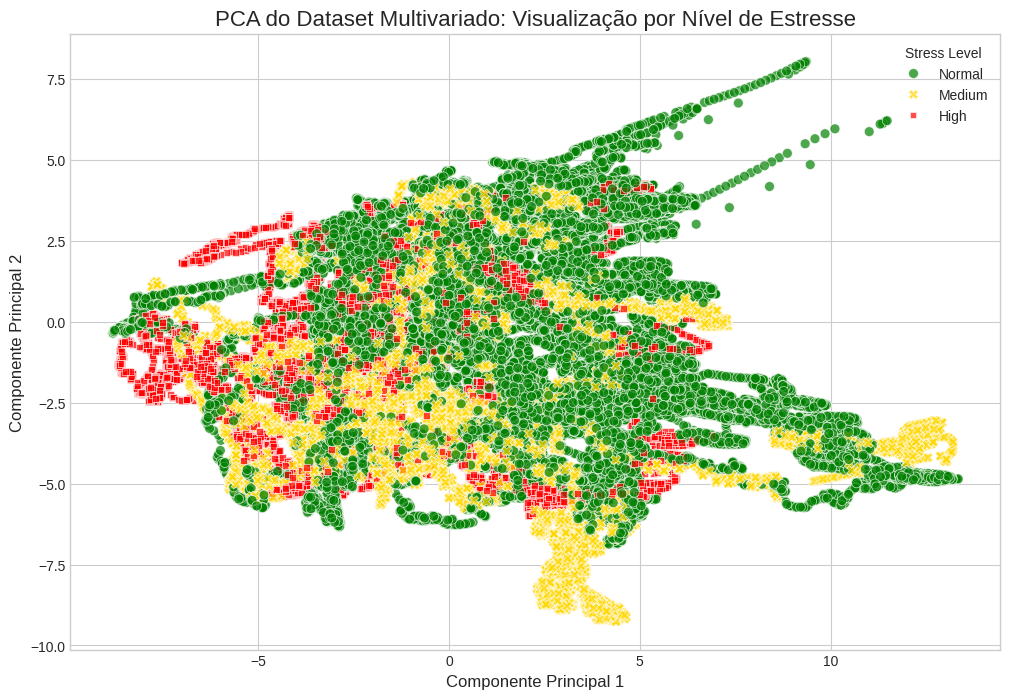

In [11]:
# Mapeia os rótulos originais para uma nomenclatura mais clara para a legenda do gráfico.
stress_level_map = {'no stress': 'Normal', 'interruption': 'Medium', 'time pressure': 'High'}
df_projetado['Stress Level'] = y.map(stress_level_map)
df_projetado['Stress Level'] = y.map(stress_level_map)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    x='CP1',
    y='CP2',
    hue='Stress Level',
    hue_order=['Normal', 'Medium', 'High'],
    style='Stress Level',
    palette={'Normal': 'green', 'Medium': 'gold', 'High': 'red'},
    data=df_projetado,
    ax=ax,
    s=50,
    alpha=0.7
)
ax.set_title('PCA do Dataset Multivariado: Visualização por Nível de Estresse', fontsize=16)
ax.set_xlabel('Componente Principal 1', fontsize=12)
ax.set_ylabel('Componente Principal 2', fontsize=12)
plt.show()

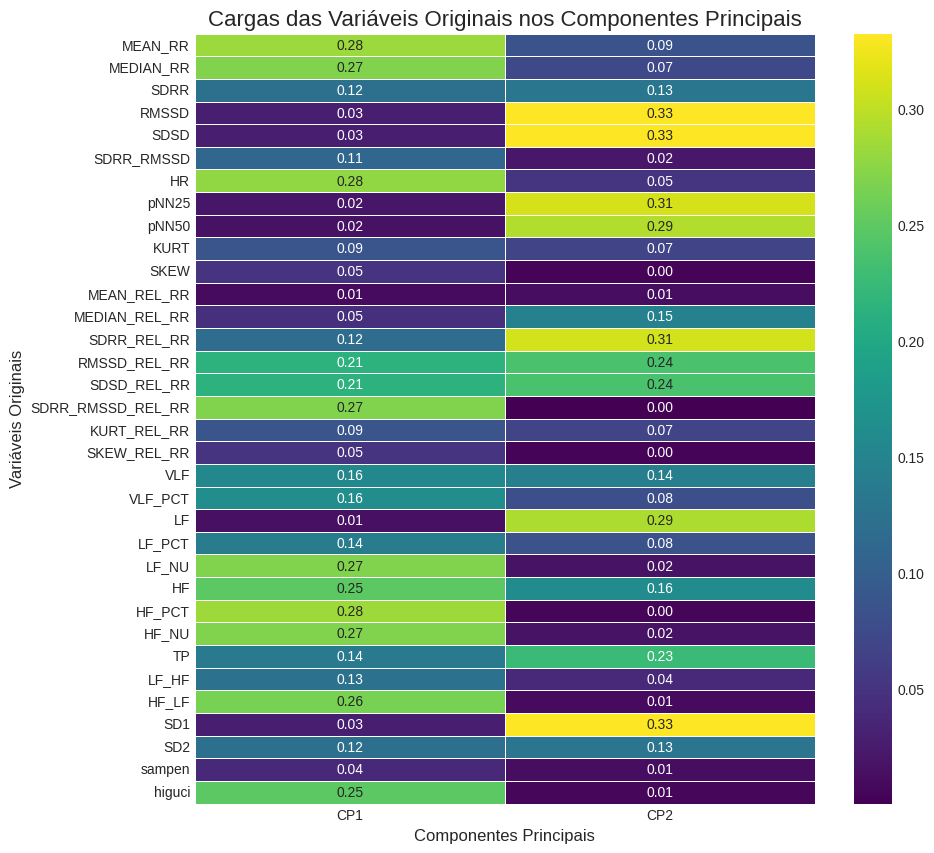

In [12]:
# Para entender o que os componentes principais realmente significam,
# analisamos a matriz de projeção, que mostra a contribuição de cada
# variável original para a formação dos componentes.

# Cria um DataFrame para a matriz de projeção para facilitar a visualização e interpretação
df_cargas = pd.DataFrame(data=matriz_projecao, index=componentes, columns=['CP1', 'CP2'])


plt.figure(figsize=(10, 10))
sns.heatmap(df_cargas.abs(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Cargas das Variáveis Originais nos Componentes Principais', fontsize=16)
plt.xlabel('Componentes Principais', fontsize=12)
plt.ylabel('Variáveis Originais', fontsize=12)

plt.show()

## Considerando **Rótulo Numérico**

In [13]:
target_column = 'HR'

X = mergedDf.drop(columns=[target_column, 'condition', 'uuid', 'datasetId'])
y = mergedDf[target_column]

In [14]:
df_projetado, variancia_explicada, matriz_projecao, componentes = analise_componentes_principais(df=X, n_componentes=2)

### Visualização dos Resultados

In [15]:
# Imprime a variância explicada pelos dois primeiros componentes
# (Só para entender quanta informação foi retida na redução de dimensionalidade)
print("--- Variância Explicada pelos Componentes Principais ---")
print(f"CP1 explica {variancia_explicada[0].real*100:.2f}% da variância total.")
print(f"CP2 explica {variancia_explicada[1].real*100:.2f}% da variância total.")
print(f"Total cumulativo: {(variancia_explicada[0].real+variancia_explicada[1].real)*100:.2f}%\n")

--- Variância Explicada pelos Componentes Principais ---
CP1 explica 26.80% da variância total.
CP2 explica 25.68% da variância total.
Total cumulativo: 52.49%



/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.12/dist-packages/pandas/core/dtypes/astype.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


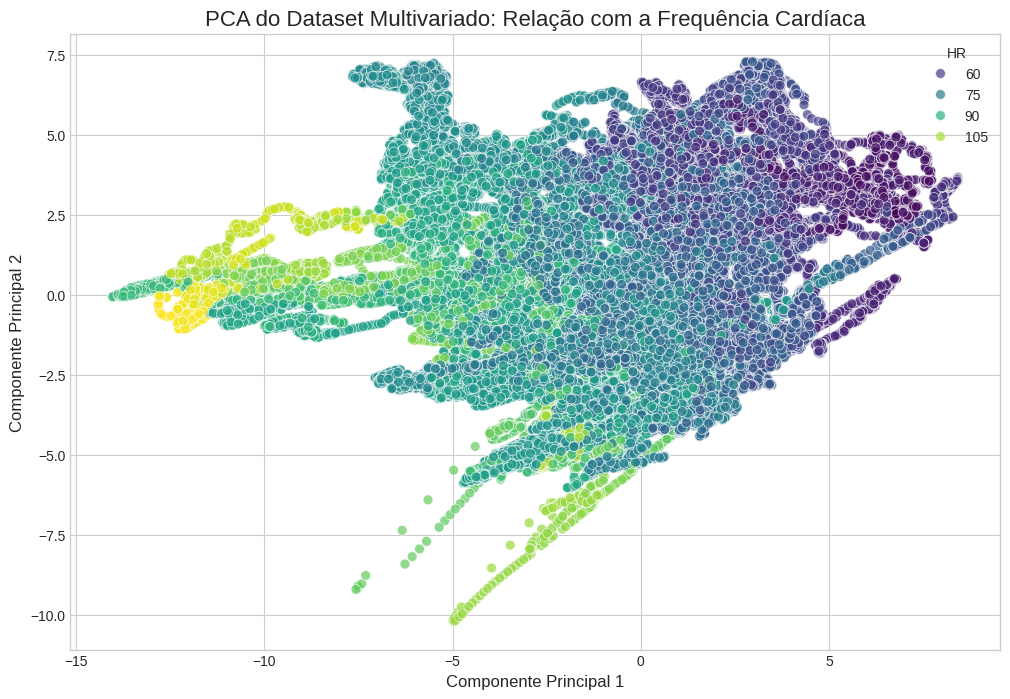

In [16]:
df_projetado['HR'] = y

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    x='CP1',
    y='CP2',
    hue='HR',           # Usa a variável numérica para a cor do ponto
    palette='viridis',
    data=df_projetado,
    ax=ax,
    s=50,
    alpha=0.7
)


ax.set_title('PCA do Dataset Multivariado: Relação com a Frequência Cardíaca', fontsize=16)
ax.set_xlabel('Componente Principal 1', fontsize=12)
ax.set_ylabel('Componente Principal 2', fontsize=12)

'''
norm = plt.Normalize(df_projetado['HR'].min(), df_projetado['HR'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Frequência Cardíaca (HR)', fontsize=12)
'''

plt.show()

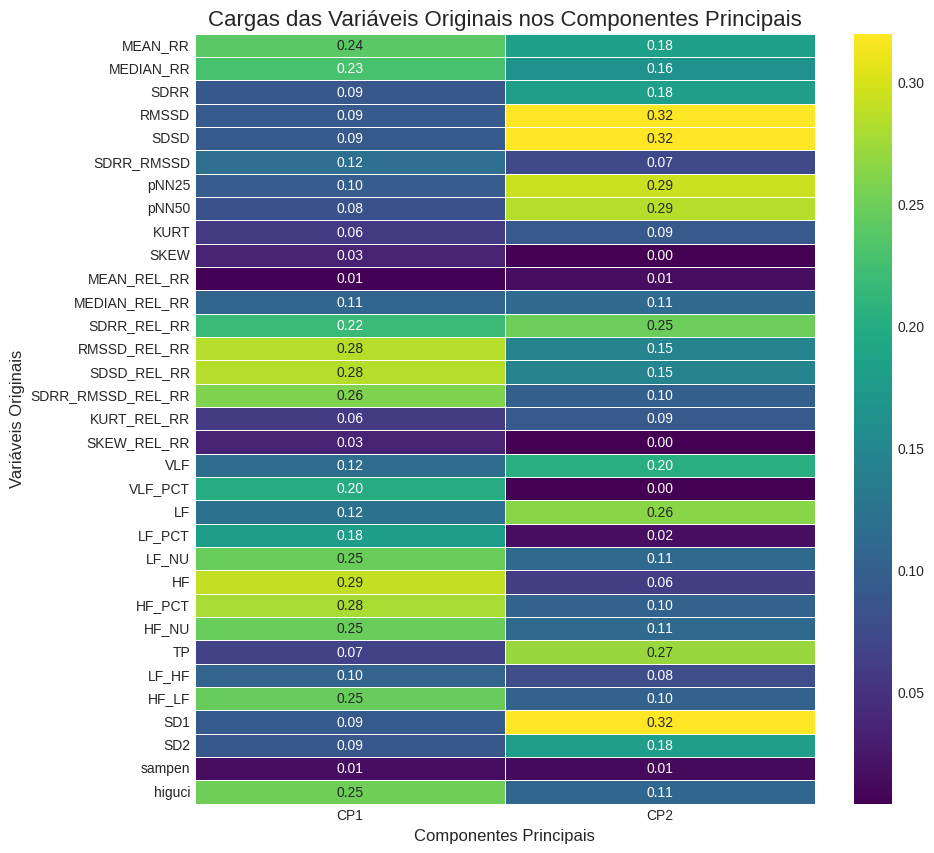

In [17]:
# Para entender o que os componentes principais realmente significam,
# analisamos a matriz de projeção, que mostra a contribuição de cada
# variável original para a formação dos componentes.

# Cria um DataFrame para a matriz de projeção para facilitar a visualização e interpretação
df_cargas = pd.DataFrame(data=matriz_projecao, index=componentes, columns=['CP1', 'CP2'])


plt.figure(figsize=(10, 10))
sns.heatmap(df_cargas.abs(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Cargas das Variáveis Originais nos Componentes Principais', fontsize=16)
plt.xlabel('Componentes Principais', fontsize=12)
plt.ylabel('Variáveis Originais', fontsize=12)

plt.show()